## Downloading packages, importing libraries and setting up clip model

In [28]:
!sudo apt-get -y install enchant-2
!pip install ftfy regex tqdm pyenchant
!pip install git+https://github.com/openai/CLIP.git
import clip
import json
import numpy as np
import torch
import torchtext
from PIL import Image
from IPython.display import Image as IM
from IPython.display import display
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import enchant
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
ms_1 = ['ViT-L/14', 'RN50x64', 'ViT-L/14@336px', 'RN50x16']
ms = ['ViT-L14', 'RN50x64', 'ViT-L14336px', 'RN50x16']
m = ms[3]
# model, preprocess = clip.load(ms_1[3], device=device)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
enchant-2 is already the newest version (2.3.2-1ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vm_llsk2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vm_llsk2
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


## Loading datasets 

In [3]:
data = None

with open('/kaggle/input/vizwiz/data/Annotations/train.json') as f:
  data = json.load(f)

In [4]:
with open('/kaggle/input/vizwiz/data/Annotations/val.json') as f:
  val_data = json.load(f)

## Getting frequency of each answer in train set
#### Used for vocab selection in one of the strategies

In [5]:
answer_freq = {}
for entry in data:
    for ans in entry['answers']:
        if ans['answer'] in answer_freq.keys():
            answer_freq[ans['answer']]+=1
        else:
            answer_freq[ans['answer']] = 1

In [6]:
len(answer_freq.keys())

40271

#### Functions that help with the vocab selection

In [7]:
def get_answers_from_dict(answers_dict):
    answers = [entry['answer'] for entry in answers_dict]
    return answers

In [8]:
def get_answer_clip(model, preprocess, img_path, answers):
    global device
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    text = clip.tokenize(answers).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    return np.argmax(probs)

In [9]:
def get_lowest_levenshtein(answers, candidates):
    scores = []
    for candidate in candidates:
        score = 0
        for answer in answers:
            score+=enchant.utils.levenshtein(candidate, answer)
        scores.append(score)
        
    return np.argmin(scores)

In [10]:
def get_most_common(answers, all_answers):
    global answer_frq
    idx = None
    freq = -1
    draws = []
    for i, answer in enumerate(answers):
        if answer in answer_freq.keys():
            fq = answer_freq[answer]
        else:
            fq = 0
        if fq>freq:
            idx = i
            freq = fq
            draws = [(answer,i)]
        elif fq==freq:
            draws.append((answer,i))
            
    if len(draws)>1:
        candids = [a[0] for a in draws]
        idx = draws[get_lowest_levenshtein(all_answers, candids)][1]
    return idx

In [11]:
def get_answer_most_common(answers, model=None, preprocess=None, img_path=None, clip=False, freq=False):
    common_idx = None
    count = -1
    draws = []
    for idx,answer in enumerate(answers):
        c = answers.count(answer)
        if c > count:
            count = c
            common_idx = idx
            draws = [(answer, idx)]
        elif c==count:
            draws.append((answer, idx))
            
    if len(draws)>1:
        tmp = [a[0] for a in draws]
        if clip:
            common_idx = draws[get_answer_clip(model, preprocess, img_path, tmp)][1]
        elif freq:
            common_idx = draws[get_most_common(tmp, answers)][1]
#         common_idx = draws[get_lowest_levenshtein(answers, tmp)][1]
    return common_idx

In [12]:
def create_df(data, selection=2):
    df = []

    for i,entry in enumerate(data):
        if selection==5:
            answers = get_answers_from_dict(entry['answers'])
            df.append([entry['image'], entry['answerable'], entry['question'], entry['answer_type'], answers])
        else:
            if entry['answerable']==0:
                answer = 'unanswerable'
            else:
                if selection==1:
                    idx = get_answer_clip(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+entry['image'], get_answers_from_dict(entry['answers']))
                elif selection==2:
                    idx = get_answer_most_common(get_answers_from_dict(entry['answers']))
                elif selection==3:
                    idx = get_answer_most_common(get_answers_from_dict(entry['answers']), model=model, preprocess=preprocess, img_path='/kaggle/input/vizwiz/data/Images/'+entry['image'], clip=True)
                elif selection==4:
                    idx = get_answer_most_common(get_answers_from_dict(entry['answers']), freq=True)    

                answer = entry['answers'][idx]['answer']

            df.append([entry['image'], entry['answerable'], entry['question'], entry['answer_type'], answer])
        if i%1000==0:
            print('Checkpoint at: ' + str(i))
    if selection==5:
        return df
    return np.array(df)

## Creating dataframes according to seletion strategy
### 1 => provide clip model with the image and all answers and choose the answer that best captions the image
### 2 => first most common answer
### 3 => most common answer with tie breaking by strategy 1
### 4 => most common answer with tie breaking highest frequency in dataset (tie breaking was changed to lowest levenshtein score instead)
### 5 => no selection strategy, add all answers

In [13]:
selection=4

In [12]:
df = create_df(data, selection)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000
Checkpoint at: 4000
Checkpoint at: 5000
Checkpoint at: 6000
Checkpoint at: 7000
Checkpoint at: 8000
Checkpoint at: 9000
Checkpoint at: 10000
Checkpoint at: 11000
Checkpoint at: 12000
Checkpoint at: 13000
Checkpoint at: 14000
Checkpoint at: 15000
Checkpoint at: 16000
Checkpoint at: 17000
Checkpoint at: 18000
Checkpoint at: 19000


In [13]:
with open('/kaggle/working/df'+str(selection)+'.npy', 'wb') as f:
    np.save(f,df)

In [14]:
with open('/kaggle/input/dfasdasd/df' + str(selection) + '.npy', 'rb') as f: 
    df = np.load(f)

In [15]:
df.shape

(20000, 5)

### separating answers, answer types, and answerability from df

In [16]:
answers = np.array([entry[4] for entry in df])

In [17]:
answer_types = np.array([entry[3] for entry in df])

In [18]:
answerable = torch.Tensor([1 if entry[1]=='1' else 0 for entry in df])

### Preparing validation set

In [ ]:
selection = 5

In [43]:
val_df = create_df(val_data, selection)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000


In [19]:
with open('/kaggle/working/val_df'+str(selection)+'.npy', 'wb') as f:
    np.save(f,val_df)

In [19]:
with open('/kaggle/input/dfasdasd/val_df' + str(selection) + '.npy', 'rb') as f: 
    val_df = np.load(f)

In [20]:
val_answers = np.array([entry[4] for entry in val_df])

In [21]:
val_answer_types = np.array([entry[3] for entry in val_df])

In [22]:
val_answerable = torch.Tensor([1 if entry[1]=='1' else 0 for entry in val_df])

## Encoding and concatenating image and text using clip's model
### Each image is augmented by rotating 90 and -90. Then the original image and the augmented ones are encoded and averaged to produce the final encoding

In [23]:
def create_samples(model, preprocess, img_path, question, rotate=True):
    global device
    samples = []
    img = Image.open(img_path)
    
    encoded_q = model.encode_text(clip.tokenize(question).to(device))
    encoded_img = model.encode_image(preprocess(img).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))
    if not rotate:
        return torch.hstack([encoded_img, encoded_q])

    # Rotate Image By 90 Degree
    rotated_image1 = img.rotate(90)
    encoded_img_r90 = model.encode_image(preprocess(rotated_image1).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))

    # Rotate Image By 180 Degree
    rotated_image2 = img.rotate(-90)
    encoded_img_rn90 = model.encode_image(preprocess(rotated_image2).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))

#     # Rotate Image By 270 Degree
#     rotated_image3 = img.rotate(270)
#     encoded_img3 = model.encode_image(preprocess(rotated_image3).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))
        
    average = (encoded_img + encoded_img_r90 + encoded_img_rn90) / 3
    return torch.hstack([average, encoded_q])
        

In [24]:
def create_X(df, rotate=False):
    global device
    X = []

    with torch.no_grad():
      for i, entry in enumerate(df):
        X.extend(create_samples(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+entry[0], entry[2], rotate))
        if i%1000==0:
            print('Checkpoint at: ' + str(i))

    return torch.vstack(X)

In [30]:
X = create_X(df, rotate=True)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000
Checkpoint at: 4000
Checkpoint at: 5000
Checkpoint at: 6000
Checkpoint at: 7000
Checkpoint at: 8000
Checkpoint at: 9000
Checkpoint at: 10000
Checkpoint at: 11000
Checkpoint at: 12000
Checkpoint at: 13000
Checkpoint at: 14000
Checkpoint at: 15000
Checkpoint at: 16000
Checkpoint at: 17000
Checkpoint at: 18000
Checkpoint at: 19000


In [31]:
torch.save(X,'/kaggle/working/X_' + m + '.pt')

In [ ]:
X = torch.load('/kaggle/input/dfasdasd/X_' + m + '.pt', map_location=device)

In [39]:
X_1 = torch.load('/kaggle/input/dfasdasd/X_' + ms[0] + '.pt', map_location=device)
X_2 = torch.load('/kaggle/input/dfasdasd/X_' + ms[1] + '.pt', map_location=device)
X_3 = torch.load('/kaggle/input/dfasdasd/X_' + ms[2] + '.pt', map_location=device)
X_4 = torch.load('/kaggle/input/dfasdasd/X_' + ms[3] + '.pt', map_location=device)
X = list(zip(X_1, X_2, X_3, X_4))

In [34]:
X_val = create_X(val_df, rotate=True)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000


In [35]:
torch.save(X_val,'/kaggle/working/X_val_' + m + '.pt')

In [28]:
X_val = torch.load('/kaggle/input/dfasdasd/X_val_' + m + '.pt', map_location=device)

In [41]:
X_val_1 = torch.load('/kaggle/input/dfasdasd/X_val_' + ms[0] + '.pt', map_location=device)
X_val_2 = torch.load('/kaggle/input/dfasdasd/X_val_' + ms[1] + '.pt', map_location=device)
X_val_3 = torch.load('/kaggle/input/dfasdasd/X_val_' + ms[2] + '.pt', map_location=device)
X_val_4 = torch.load('/kaggle/input/dfasdasd/X_val_' + ms[3] + '.pt', map_location=device)
X_val = list(zip(X_val_1, X_val_2, X_val_3, X_val_4))

In [42]:
y = [(a_type, a) for a_type, a in zip(answer_types, answers)]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=answer_types)

## Encoding answers
### We used a label binarizer not a label encoder to prevent bias towards some answers. We also chose label binarizer instead of one hot encoder. While there aren't any significant differences between the two, label binarizer is more aimed towards labels as opposed to one hot encoder that is usually used to encode features.

In [44]:
answers_train = []
answer_types_train = []
for a_type, a in y_train:
    answer_types_train.append(a_type)
    answers_train.append(a)

In [45]:
answers_test = []
answer_types_test = []
for a_type, a in y_test:
    answer_types_test.append(a_type)
    answers_test.append(a)

In [46]:
lb_types = preprocessing.LabelBinarizer()

encoded_answer_types_train = lb_types.fit_transform(answer_types_train)

In [47]:
lb_types.classes_

array(['number', 'other', 'unanswerable', 'yes/no'], dtype='<U12')

In [48]:
lb_answers = preprocessing.LabelBinarizer()

encoded_answers_train = lb_answers.fit_transform(answers_train)

In [49]:
lb_answers.classes_.shape

(4690,)

#### Combining answers and answer types into y as they will both be used to measure loss and accuracy

In [50]:
y_train = [(a_type, a) for a_type, a in zip(encoded_answer_types_train, encoded_answers_train)]

In [51]:
val_encoded_answer_types = lb_types.transform(val_answer_types)
# val_encoded_answers = [lb_answers.transform(a) for a in val_answers]
val_encoded_answers = lb_answers.transform(val_answers)
y_val = [(a_type, a) for a_type, a in zip(val_encoded_answer_types, val_encoded_answers)]

In [52]:
test_encoded_answer_types = lb_types.transform(answer_types_test)
# val_encoded_answers = [lb_answers.transform(a) for a in val_answers]
test_encoded_answers = lb_answers.transform(answers_test)
y_test = [(a_type, a) for a_type, a in zip(test_encoded_answer_types, test_encoded_answers)]

#### This shows that out of all answers in the val set, ~500 answers are not present in the train set. Which means they will always be misclassified.

In [53]:
c = 0
for ans in val_encoded_answers:
    c += ans.sum()
print(c)
print(len(val_encoded_answers))

2595
3173


#### This is not the case however for answer types. And this makes sense and is very trivial as there are only 4 answer types.

In [54]:
c = 0
for ans in val_encoded_answer_types:
    c += ans.sum()
print(c)
print(len(val_encoded_answer_types))

3173
3173


## Building data loader

In [55]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class VQADataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

## The model
### This follows the architecture inthe paper

In [121]:
class VQA_Network(nn.Module):
    def __init__(self, num_classes, vocab_size, hidden_dim, embedding_dim):
        super(VQA_Network, self).__init__()

        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.fc2_answers = nn.Linear(hidden_dim, vocab_size)

        self.fc2_aux = nn.Linear(hidden_dim, num_classes)
        self.fc3_aux = nn.Linear(num_classes, vocab_size)

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.to(dtype=torch.float32)
        x = self.norm1(x)
        x = self.dropout1(x)
        x = self.fc(x)

        atype = self.fc2_aux(x)
        aux = self.fc3_aux(atype)
        
        x = self.norm2(x)
        x = self.dropout2(x)
        answers = self.fc2_answers(x)

        answers = answers * self.sigmoid(aux)

        return answers, atype


#### This function cacluclates accurcy for a batch based on the formula given in the vizwiz grand challenge

In [57]:
def calculate_acc(batch_output, labels):
    acc = 0
    for output, answers in zip(batch_output, labels):
        c = 0
        for answer in answers:
            if (torch.argmax(output)==torch.argmax(torch.Tensor(answer))):
                c+=1
        acc+=min((c/3),1)
    return acc

In [59]:
train_set = DataLoader(VQADataset(X_train, y_train), batch_size=32)
test_set = DataLoader(VQADataset(X_test, y_test), batch_size=32)
val_set = DataLoader(VQADataset(X_val, y_val), batch_size=32)

## Main train loop

In [95]:
def train_val_plot(num_epochs, model, train_set, val_set, x_i, save=False):
    global device
    train_accs_a = []
    val_accs_a = []
    train_accs_at = []
    val_accs_at = []
    train_loss_a = []
    val_loss_a = []
    train_loss_at = []
    val_loss_at = []
    highest_acc = -1
    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss_a = 0.0
        running_loss_at = 0.0
        acc_a = 0
        acc_at = 0
        val_running_loss_a = 0.0
        val_running_loss_at = 0.0
        val_acc_a = 0
        val_acc_at = 0

        for xs, labels in train_set:
            # Move data to the device
            xs = xs[x_i].to(device)
            atypeset, answerset = labels
            atypeset = torch.Tensor(atypeset).float().to(device)
            answerset = torch.Tensor(answerset).float().to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            answers, atypes = model(xs)
            # print(xs.size())
            # print(labelset.size())
            # Compute loss
            answer_loss = criterion(answers, answerset)
            atype_loss = criterion(atypes, atypeset)

            # Compute loss
            loss = answer_loss + atype_loss

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Update running loss
            running_loss_a += answer_loss.item()
            running_loss_at += atype_loss.item()
            acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
            acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

        acc_a = acc_a / len(y)
        acc_at = acc_at / len(y)
        # Calculate average loss for the epoch
        average_loss_a = running_loss_a / len(y)
        average_loss_at = running_loss_at / len(y)

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss_a: {average_loss_a:.4f}, Loss_at: {average_loss_at:.4f}", end=' ')
        print(f"Acc_a: {acc_a:.4f}, Acc_at: {acc_at:.4f}", end='\t')
        train_accs_a.append(acc_a.cpu())
        train_accs_at.append(acc_at.cpu())
        train_loss_a.append(average_loss_a)
        train_loss_at.append(average_loss_at)

        with torch.no_grad():
            model.eval()
            for xs, labels in val_set:
                # Move data to the device
                xs = xs[x_i].to(device)
                atypeset, answerset = labels
                atypeset = torch.Tensor(atypeset).float().to(device)
                answerset = torch.Tensor(answerset).float().to(device)

                # Forward pass
                answers, atypes = model(xs)
                # print(xs.size())
                # print(labelset.size())
                # Compute loss
                answer_loss = criterion(answers, answerset)

                # Compute loss
                atype_loss = criterion(atypes, atypeset)

                # Update running loss
                val_running_loss_a += answer_loss.item()
                val_running_loss_at += atype_loss.item()
    #             val_acc_a += calculate_acc(answers, answerset)
                val_acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
                val_acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

            val_acc_a = val_acc_a / len(y_val)
            if val_acc_a>highest_acc and save!=False:
                torch.save(model.state_dict(), save)
                highest_acc = val_acc_a
            val_acc_at = val_acc_at / len(y_val)
            # Calculate average loss for the epoch
            val_average_loss_a = val_running_loss_a / len(y_val)
            val_average_loss_at = val_running_loss_at / len(y_val)

            # Print progress
            print(f"Validation: Loss_a: {val_average_loss_a:.4f}, Loss_at: {val_average_loss_at:.4f}", end=' ')
            print(f"Acc_a: {val_acc_a:.4f}, Acc_at: {val_acc_at:.4f}")
            val_accs_a.append(val_acc_a.cpu())
            val_accs_at.append(val_acc_at.cpu())
            val_loss_a.append(val_average_loss_a)
            val_loss_at.append(val_average_loss_at)
            
    



    # Training complete
    
    epochs = range(1,num_epochs+1)

    # Creating a figure with two subplots
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
    (ax1, ax2, ax3, ax4) = ax.flatten()

    ax1.plot(epochs, train_loss_a, label='Train Answer Loss')
    ax1.plot(epochs, val_loss_a, label='Validation Answer Loss')
    ax2.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Answer Loss')
    ax1.legend()

    ax2.plot(epochs, train_loss_at, label='Train Answer Type Loss')
    ax2.plot(epochs, val_loss_at, label='Validation Answer Type Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Answer Type Loss')
    ax2.legend()

    ax3.plot(epochs, train_accs_a, label='Train Answer Accuracy')
    ax3.plot(epochs, val_accs_a, label='Validation Answer Accuracy')
    ax4.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Answer Accuracy')
    ax3.legend()

    ax4.plot(epochs, train_accs_at, label='Train Answer Type Accuracy')
    ax4.plot(epochs, val_accs_at, label='Validation Answer Type Accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Answer Type Accuracy')
    ax4.legend()

    fig.tight_layout()

    plt.show()


In [72]:
num_classes = 4
vocab_size = 4690
hidden_dim = 512
embedding_dim = [768*2, 1024*2, 768*2, 768*2]
num_epochs = 70

Epoch [1/70], Loss_a: 0.1630, Loss_at: 0.0216 Acc_a: 0.3237, Acc_at: 0.6698	Validation: Loss_a: 0.0890, Loss_at: 0.0211 Acc_a: 0.3943, Acc_at: 0.7662
Epoch [2/70], Loss_a: 0.1400, Loss_at: 0.0195 Acc_a: 0.3512, Acc_at: 0.6907	Validation: Loss_a: 0.0763, Loss_at: 0.0197 Acc_a: 0.4091, Acc_at: 0.7520
Epoch [3/70], Loss_a: 0.1189, Loss_at: 0.0184 Acc_a: 0.3841, Acc_at: 0.7035	Validation: Loss_a: 0.0678, Loss_at: 0.0182 Acc_a: 0.4371, Acc_at: 0.7617
Epoch [4/70], Loss_a: 0.1005, Loss_at: 0.0181 Acc_a: 0.4112, Acc_at: 0.7048	Validation: Loss_a: 0.0609, Loss_at: 0.0179 Acc_a: 0.4551, Acc_at: 0.7513
Epoch [5/70], Loss_a: 0.0845, Loss_at: 0.0182 Acc_a: 0.4424, Acc_at: 0.7018	Validation: Loss_a: 0.0583, Loss_at: 0.0182 Acc_a: 0.4696, Acc_at: 0.7454
Epoch [6/70], Loss_a: 0.0702, Loss_at: 0.0183 Acc_a: 0.4830, Acc_at: 0.7040	Validation: Loss_a: 0.0557, Loss_at: 0.0182 Acc_a: 0.4765, Acc_at: 0.7447
Epoch [7/70], Loss_a: 0.0581, Loss_at: 0.0184 Acc_a: 0.5245, Acc_at: 0.7074	Validation: Loss_a: 0.05

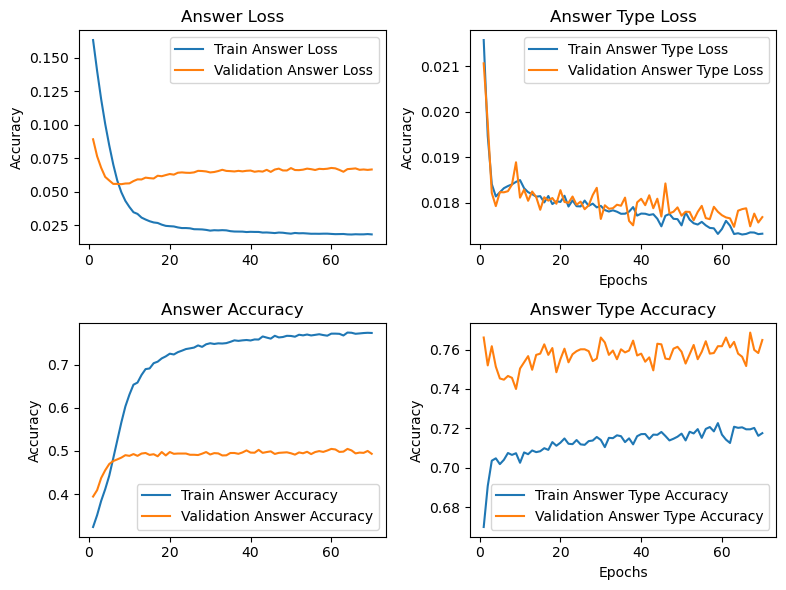

In [122]:
# Instantiate the model
model = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim[0]).to(device)

train_val_plot(num_epochs, model, train_set, val_set, 0, save='/kaggle/working/'+ ms[0]+'.pt')

Epoch [1/70], Loss_a: 0.1635, Loss_at: 0.0219 Acc_a: 0.3227, Acc_at: 0.6697	Validation: Loss_a: 0.0954, Loss_at: 0.0200 Acc_a: 0.3643, Acc_at: 0.7482
Epoch [2/70], Loss_a: 0.1428, Loss_at: 0.0191 Acc_a: 0.3410, Acc_at: 0.7057	Validation: Loss_a: 0.0811, Loss_at: 0.0181 Acc_a: 0.4075, Acc_at: 0.7570
Epoch [3/70], Loss_a: 0.1229, Loss_at: 0.0179 Acc_a: 0.3682, Acc_at: 0.7111	Validation: Loss_a: 0.0735, Loss_at: 0.0181 Acc_a: 0.4292, Acc_at: 0.7551
Epoch [4/70], Loss_a: 0.1062, Loss_at: 0.0175 Acc_a: 0.3971, Acc_at: 0.7164	Validation: Loss_a: 0.0658, Loss_at: 0.0175 Acc_a: 0.4437, Acc_at: 0.7598
Epoch [5/70], Loss_a: 0.0900, Loss_at: 0.0174 Acc_a: 0.4300, Acc_at: 0.7154	Validation: Loss_a: 0.0612, Loss_at: 0.0174 Acc_a: 0.4614, Acc_at: 0.7734
Epoch [6/70], Loss_a: 0.0745, Loss_at: 0.0173 Acc_a: 0.4712, Acc_at: 0.7200	Validation: Loss_a: 0.0589, Loss_at: 0.0171 Acc_a: 0.4690, Acc_at: 0.7734
Epoch [7/70], Loss_a: 0.0619, Loss_at: 0.0173 Acc_a: 0.5139, Acc_at: 0.7197	Validation: Loss_a: 0.05

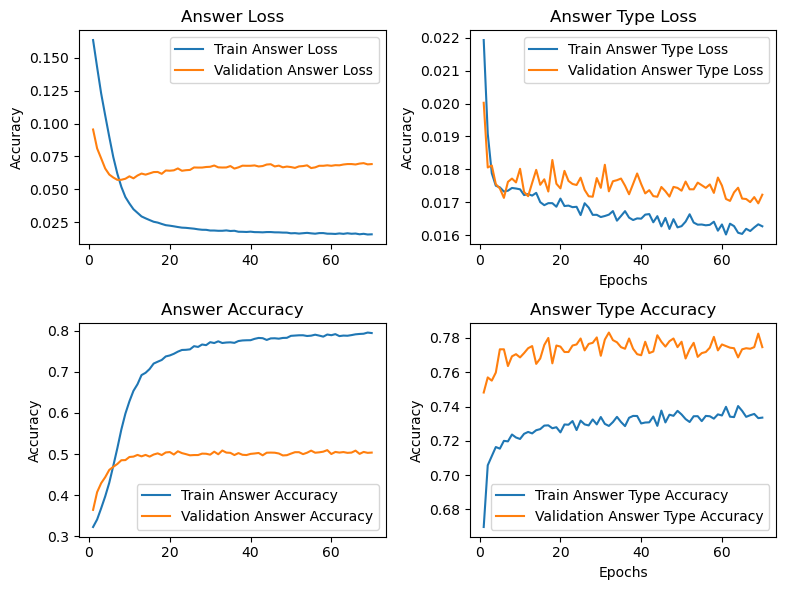

In [123]:
# Instantiate the model
model = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim[1]).to(device)

train_val_plot(num_epochs, model, train_set, val_set, 1, save='/kaggle/working/'+ ms[1]+'.pt')

Epoch [1/70], Loss_a: 0.1628, Loss_at: 0.0220 Acc_a: 0.3291, Acc_at: 0.6668	Validation: Loss_a: 0.0890, Loss_at: 0.0204 Acc_a: 0.3917, Acc_at: 0.7564
Epoch [2/70], Loss_a: 0.1397, Loss_at: 0.0195 Acc_a: 0.3554, Acc_at: 0.6933	Validation: Loss_a: 0.0760, Loss_at: 0.0199 Acc_a: 0.4138, Acc_at: 0.7488
Epoch [3/70], Loss_a: 0.1188, Loss_at: 0.0185 Acc_a: 0.3839, Acc_at: 0.7036	Validation: Loss_a: 0.0660, Loss_at: 0.0178 Acc_a: 0.4428, Acc_at: 0.7671
Epoch [4/70], Loss_a: 0.0999, Loss_at: 0.0181 Acc_a: 0.4157, Acc_at: 0.7059	Validation: Loss_a: 0.0602, Loss_at: 0.0176 Acc_a: 0.4582, Acc_at: 0.7630
Epoch [5/70], Loss_a: 0.0836, Loss_at: 0.0182 Acc_a: 0.4498, Acc_at: 0.7013	Validation: Loss_a: 0.0563, Loss_at: 0.0173 Acc_a: 0.4699, Acc_at: 0.7769
Epoch [6/70], Loss_a: 0.0696, Loss_at: 0.0182 Acc_a: 0.4882, Acc_at: 0.7079	Validation: Loss_a: 0.0551, Loss_at: 0.0178 Acc_a: 0.4806, Acc_at: 0.7658
Epoch [7/70], Loss_a: 0.0584, Loss_at: 0.0183 Acc_a: 0.5231, Acc_at: 0.7061	Validation: Loss_a: 0.05

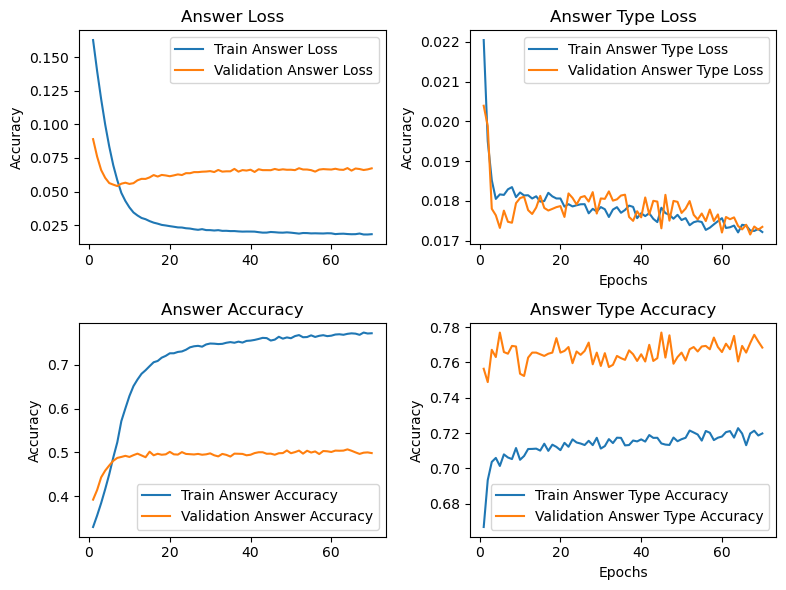

In [124]:
# Instantiate the model
model = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim[2]).to(device)

train_val_plot(num_epochs, model, train_set, val_set, 2, save='/kaggle/working/'+ ms[2]+'.pt')

Epoch [1/70], Loss_a: 0.1646, Loss_at: 0.0220 Acc_a: 0.3246, Acc_at: 0.6668	Validation: Loss_a: 0.0947, Loss_at: 0.0199 Acc_a: 0.3747, Acc_at: 0.7545
Epoch [2/70], Loss_a: 0.1458, Loss_at: 0.0197 Acc_a: 0.3353, Acc_at: 0.6940	Validation: Loss_a: 0.0856, Loss_at: 0.0188 Acc_a: 0.3873, Acc_at: 0.7621
Epoch [3/70], Loss_a: 0.1276, Loss_at: 0.0185 Acc_a: 0.3583, Acc_at: 0.6993	Validation: Loss_a: 0.0777, Loss_at: 0.0182 Acc_a: 0.4062, Acc_at: 0.7630
Epoch [4/70], Loss_a: 0.1126, Loss_at: 0.0180 Acc_a: 0.3765, Acc_at: 0.7061	Validation: Loss_a: 0.0706, Loss_at: 0.0180 Acc_a: 0.4211, Acc_at: 0.7567
Epoch [5/70], Loss_a: 0.0991, Loss_at: 0.0180 Acc_a: 0.3955, Acc_at: 0.7085	Validation: Loss_a: 0.0648, Loss_at: 0.0181 Acc_a: 0.4396, Acc_at: 0.7476
Epoch [6/70], Loss_a: 0.0851, Loss_at: 0.0179 Acc_a: 0.4264, Acc_at: 0.7086	Validation: Loss_a: 0.0619, Loss_at: 0.0180 Acc_a: 0.4519, Acc_at: 0.7482
Epoch [7/70], Loss_a: 0.0720, Loss_at: 0.0179 Acc_a: 0.4658, Acc_at: 0.7109	Validation: Loss_a: 0.06

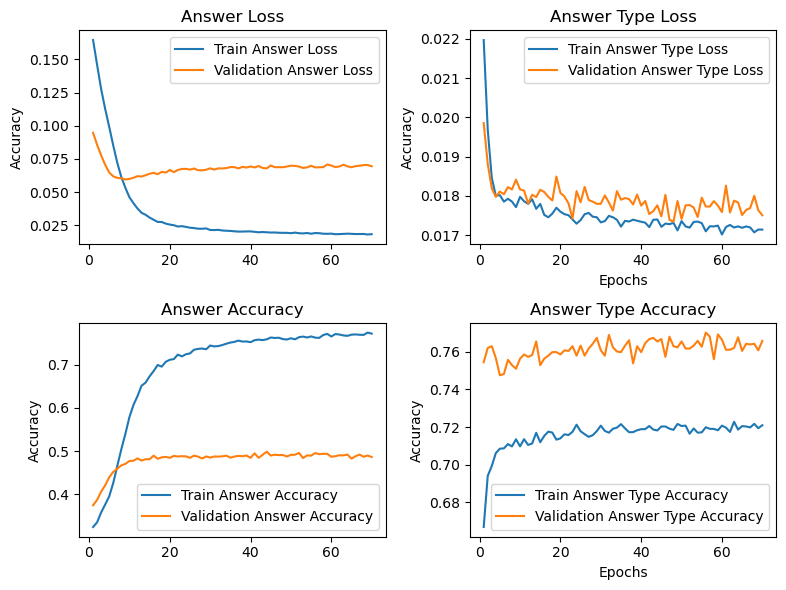

In [125]:
# Instantiate the model
model = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim[3]).to(device)

train_val_plot(num_epochs, model, train_set, val_set, 3, save='/kaggle/working/'+ ms[3]+'.pt')

## Ensemble using different models

In [126]:
val_acc_a = 0
val_acc_at = 0
val_running_loss_a = 0
val_running_loss_at = 0
num_models = 4

criterion = nn.CrossEntropyLoss()

# Instantiate the model
models = []
for i in range(num_models):
    model = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim[i]).to(device)
    model.load_state_dict(torch.load('/kaggle/working/'+ms[i]+'.pt'))
    models.append(model)

with torch.no_grad():
    [model.eval() for model in models]
    for xs, labels in val_set:
        # Move data to the device
        for x_i in xs:
            x_i = x_i.to(device)
        atypeset, answerset = labels
        atypeset = torch.Tensor(atypeset).float().to(device)
        answerset = torch.Tensor(answerset).float().to(device)

        # Forward pass
        answers = torch.zeros(answerset.size()[0], vocab_size).to(device)
        atypes = torch.zeros(atypeset.size()[0], num_classes).to(device)
        for model, x_i in zip(models, xs):
            answers1, atypes1 = model(x_i)
            answers += answers1
            atypes += atypes1
        answers = answers/num_models
        atypes = atypes/num_models

        # Compute loss
        answer_loss = criterion(answers, answerset)

        # Compute loss
        atype_loss = criterion(atypes, atypeset)

        # Update running loss
        val_running_loss_a += answer_loss.item()
        val_running_loss_at += atype_loss.item()
#             val_acc_a += calculate_acc(answers, answerset)
        val_acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
        val_acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

    val_acc_a = val_acc_a / len(y_val)
    val_acc_at = val_acc_at / len(y_val)
    # Calculate average loss for the epoch
    val_average_loss_a = val_running_loss_a / len(y_val)
    val_average_loss_at = val_running_loss_at / len(y_val)

    # Print progress
    print(f"Validation: Loss_a: {val_average_loss_a:.4f}, Loss_at: {val_average_loss_at:.4f}", end=' ')
    print(f"Acc_a: {val_acc_a:.4f}, Acc_at: {val_acc_at:.4f}")


Validation: Loss_a: 0.0627, Loss_at: 0.0163 Acc_a: 0.5147, Acc_at: 0.7794


## Evaluation of the final model using test set

In [127]:
test_acc_a = 0
test_acc_at = 0
test_running_loss_a = 0
test_running_loss_at = 0
num_models = 4

criterion = nn.CrossEntropyLoss()

# Instantiate the model
models = []
for i in range(num_models):
    model = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim[i]).to(device)
    model.load_state_dict(torch.load('/kaggle/working/'+ms[i]+'.pt'))
    models.append(model)

with torch.no_grad():
    [model.eval() for model in models]
    for xs, labels in test_set:
        # Move data to the device
        for x_i in xs:
            x_i = x_i.to(device)
        atypeset, answerset = labels
        atypeset = torch.Tensor(atypeset).float().to(device)
        answerset = torch.Tensor(answerset).float().to(device)

        # Forward pass
        answers = torch.zeros(answerset.size()[0], vocab_size).to(device)
        atypes = torch.zeros(atypeset.size()[0], num_classes).to(device)
        for model, x_i in zip(models, xs):
            answers1, atypes1 = model(x_i)
            answers += answers1
            atypes += atypes1
        answers = answers/num_models
        atypes = atypes/num_models

        # Compute loss
        answer_loss = criterion(answers, answerset)

        # Compute loss
        atype_loss = criterion(atypes, atypeset)

        # Update running loss
        test_running_loss_a += answer_loss.item()
        test_running_loss_at += atype_loss.item()
#             val_acc_a += calculate_acc(answers, answerset)
        test_acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
        test_acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

    test_acc_a = test_acc_a / len(y_test)
    test_acc_at = test_acc_at / len(y_test)
    # Calculate average loss for the epoch
    test_average_loss_a = test_running_loss_a / len(y_test)
    test_average_loss_at = test_running_loss_at / len(y_test)

    # Print progress
    print(f"Model final evaluation: Loss_a: {test_average_loss_a:.4f}, Loss_at: {test_average_loss_at:.4f}", end=' ')
    print(f"Acc_a: {test_acc_a:.4f}, Acc_at: {test_acc_at:.4f}")


Model final evaluation: Loss_a: 0.0726, Loss_at: 0.0171 Acc_a: 0.5160, Acc_at: 0.7620


In [ ]:
idx = 700

answer, atype = model(X_val[idx])
print(lb_answers.classes_[torch.argmax(answer)])
print(lb_types.classes_[torch.argmax(atype)])
print('-------------------')
print(val_df[idx])

In [ ]:
display(IM(filename='/kaggle/input/vizwiz/data/Images/'+val_df[idx][0]))

In [48]:
train_set = DataLoader(VQADataset(X, answerable, single=True), batch_size=32)
val_set = DataLoader(VQADataset(X_val, val_answerable, single=True), batch_size=32)

In [58]:
class VQA_Answerability(nn.Module):
    def __init__(self, embedding_dim):
        super(VQA_Answerability, self).__init__()

        self.fc = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.to(dtype=torch.float32)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [59]:
embedding_dim = 1024
train_accs = []
val_accs = []

num_epochs = 200

# Instantiate the model
model = VQA_Answerability(embedding_dim).to(device)

# Define loss function
criterion = nn.BCELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    acc = 0
    val_running_loss = 0.0
    val_acc = 0

    for xs, labelset in train_set:
        # Move data to the device
        xs = xs.to(device)
        labelset = labelset.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(xs).squeeze()
        
        # Compute loss
        loss = criterion(output, labelset)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        acc += (torch.round(output) == labelset).float().sum()

    acc = acc / len(answerable)
    # Calculate average loss for the epoch
    average_loss = running_loss / len(answerable)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}", end=' ')
    print(f"Acc: {acc:.4f}", end='\t')
    train_accs.append(acc.cpu())
    
    with torch.no_grad():
        model.eval()
        for xs, labelset in val_set:
            # Move data to the device
            xs = xs.to(device)
            labelset = labelset.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(xs).squeeze()

            # Compute loss
            loss = criterion(output, labelset)

            # Update running loss
            val_running_loss += loss.item()
            val_acc += (torch.round(output) == labelset).float().sum()

        val_acc = val_acc / len(val_answerable)
        # Calculate average loss for the epoch
        val_average_loss = val_running_loss / len(val_answerable)

        # Print progress
        print(f"Validation: Loss_at: {val_average_loss:.4f}", end=' ')
        print(f"Acc: {val_acc:.4f}")
        val_accs.append(val_acc.cpu())

# Training complete

Epoch [1/200], Loss: 0.0172 Acc: 0.7171	Validation: Loss_at: 0.0160 Acc: 0.7340
Epoch [2/200], Loss: 0.0154 Acc: 0.7519	Validation: Loss_at: 0.0150 Acc: 0.7633
Epoch [3/200], Loss: 0.0147 Acc: 0.7718	Validation: Loss_at: 0.0146 Acc: 0.7772
Epoch [4/200], Loss: 0.0144 Acc: 0.7818	Validation: Loss_at: 0.0143 Acc: 0.7835
Epoch [5/200], Loss: 0.0142 Acc: 0.7901	Validation: Loss_at: 0.0141 Acc: 0.7879
Epoch [6/200], Loss: 0.0140 Acc: 0.7953	Validation: Loss_at: 0.0140 Acc: 0.7907
Epoch [7/200], Loss: 0.0139 Acc: 0.7986	Validation: Loss_at: 0.0139 Acc: 0.7933
Epoch [8/200], Loss: 0.0138 Acc: 0.8013	Validation: Loss_at: 0.0139 Acc: 0.7958
Epoch [9/200], Loss: 0.0137 Acc: 0.8043	Validation: Loss_at: 0.0138 Acc: 0.7974
Epoch [10/200], Loss: 0.0136 Acc: 0.8063	Validation: Loss_at: 0.0138 Acc: 0.7992
Epoch [11/200], Loss: 0.0136 Acc: 0.8079	Validation: Loss_at: 0.0137 Acc: 0.7992
Epoch [12/200], Loss: 0.0135 Acc: 0.8097	Validation: Loss_at: 0.0137 Acc: 0.8008
Epoch [13/200], Loss: 0.0135 Acc: 0.8

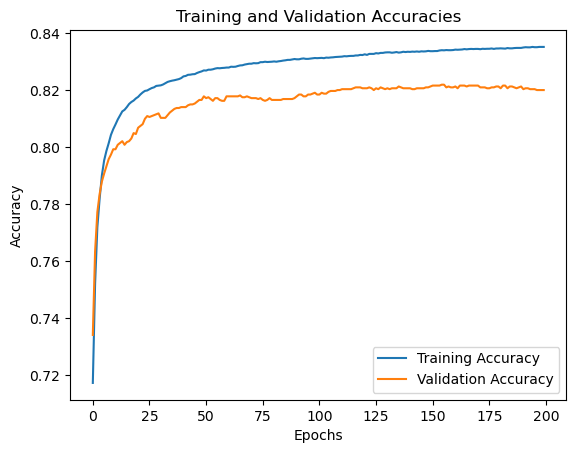

In [61]:
# Plotting the accuracies
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')

# Adding legend
plt.legend()

# Display the plot
plt.show()